In [ ]:
# CELLA 1: Setup e Import

!pip install -q datasets emoji

import os, zipfile, requests, io, re, random
import pandas as pd, numpy as np
import emoji, html
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from pathlib import Path

if torch.cuda.is_available():
    print("GPU disponibile")

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
SAMPLE_SIZE = 10000
MAX_LEN = 128
BATCH = 16
LOW_CONF_THRESHOLD = 0.60


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.7 MB/s eta 0:00:00
GPU disponibile


In [ ]:
#Download e Preprocessing Dataset

zip_url = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
data_dir = "./sentiment140_data"
os.makedirs(data_dir, exist_ok=True)
csv_path = os.path.join(data_dir, "training.1600000.processed.noemoticon.csv")

if not os.path.exists(csv_path):
    r = requests.get(zip_url, timeout=120)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(data_dir)

cols = ["target","id","date","query","user","text"]
df = pd.read_csv(csv_path, encoding="latin-1", names=cols)
df = df[["target","text"]]
# Mappa 0->0 (Negativo), 4->1 (Positivo)
df["target"] = df["target"].map({0:0, 4:1})
df = df.dropna().reset_index(drop=True)

def preprocess_social(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = html.unescape(text)
    t = re.sub(r"@\w+", "@user", t)
    t = re.sub(r"http\S+|www\.\S+", "http", t)
    t = re.sub(r"#(\w+)", r"\1", t)
    t = emoji.demojize(t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["text_clean"] = df["text"].astype(str).apply(preprocess_social)
df = df.groupby("target").apply(lambda x: x.sample(min(len(x), SAMPLE_SIZE//2), random_state=42)).reset_index(drop=True)

train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["target"])
print(f"Train: {len(train_df)}, Test: {len(test_df)}")
print(f"Distribuzione: {df['target'].value_counts().sort_index().to_dict()}")

Train: 8500, Test: 1500
Distribuzione: {0: 5000, 1: 5000}


/tmp/ipython-input-305863867.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("target").apply(lambda x: x.sample(min(len(x), SAMPLE_SIZE//2), random_state=42)).reset_index(drop=True)


In [ ]:
#Tokenizzazione

tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

train_ds = Dataset.from_pandas(train_df[["text_clean","target"]].rename(columns={"text_clean":"text", "target":"labels"}))
test_ds = Dataset.from_pandas(test_df[["text_clean","target"]].rename(columns={"text_clean":"text", "target":"labels"}))

train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds = test_ds.map(tokenize_batch, batched=True)

train_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
test_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Accuracy,F1
200,0.418900,0.375360,0.831333,0.831306
400,0.395200,0.361241,0.836000,0.835995


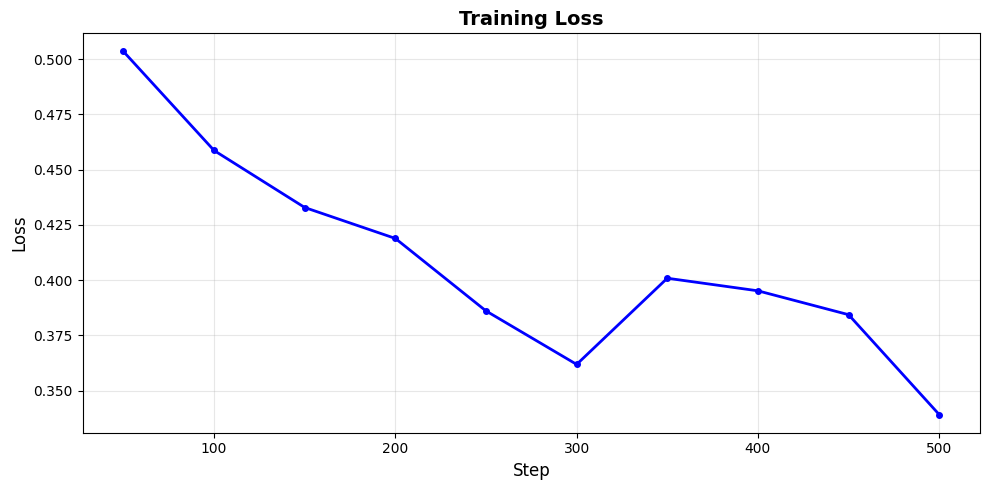


=== TRAINING SUMMARY ===
Initial Loss: 0.5035
Final Loss: 0.3392
Loss Reduction: 32.6%


In [ ]:
#Training

# Questo dice di scartare la vecchia testa di classificazione (3 etichette)
# e inizializzarne una nuova (2 etichette) per il task.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=2,
    ignore_mismatched_sizes=True #IGNORA I NEUTRALI
)

os.environ["WANDB_DISABLED"] = "true"

args = TrainingArguments(
    output_dir="./hf_retrained_model",
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=1,
    save_strategy="epoch",
    eval_strategy="steps",
    eval_steps=200,
    learning_rate=2e-5,
    logging_steps=50,
    disable_tqdm=False,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(model=model, args=args, train_dataset=train_ds, eval_dataset=test_ds, compute_metrics=compute_metrics)

trainer.train()
trainer.save_model("./hf_retrained_model")

# Plot Training Loss
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
steps_train = [log['step'] for log in trainer.state.log_history if 'loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(steps_train, train_losses, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== TRAINING SUMMARY ===")
print(f"Initial Loss: {train_losses[0]:.4f}")
print(f"Final Loss: {train_losses[-1]:.4f}")
print(f"Loss Reduction: {100*(train_losses[0]-train_losses[-1])/train_losses[0]:.1f}%")

Accuracy: 0.8413
F1: 0.8413

               precision    recall  f1-score   support

    Negativo       0.84      0.85      0.84       750
    Positivo       0.85      0.84      0.84       750

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



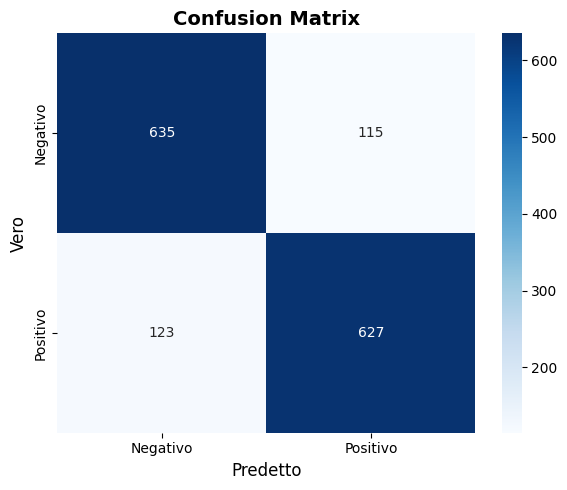


Low confidence (<0.6): 2


In [ ]:
#Evaluation Base

pred_output = trainer.predict(test_ds)
logits = pred_output.predictions
probs = softmax(logits, axis=1)
preds = np.argmax(probs, axis=1)
labels = pred_output.label_ids

acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="weighted", zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"F1: {f1:.4f}")
print("\n", classification_report(labels, preds, target_names=['Negativo', 'Positivo'], zero_division=0))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predetto", fontsize=12)
plt.ylabel("Vero", fontsize=12)
plt.tight_layout()
plt.show()

# Low confidence
low_conf = []
for i in range(min(20, len(probs))):
    top_score = float(np.max(probs[i]))
    if top_score < LOW_CONF_THRESHOLD:
        low_conf.append((i, int(labels[i]), int(np.argmax(probs[i])), top_score))

if low_conf:
    print(f"\nLow confidence (<{LOW_CONF_THRESHOLD}): {len(low_conf)}")

Il modello ha sbagliato quasi allo stesso modo per entrambe: ha confuso 123 Negativi per Positivi e 117 Positivi per Negativi.

Questo bilanciamento è OTTIMO Significa che il modello non è sbilanciato: non ha una preferenza nel classificare tutto come "Positivo" o "Negativo"

In [ ]:
# Pipeline Inferenza

# Diciamo al modello che l'etichetta 0 è "negative" e l'etichetta 1 è "positive"
#sovrascrive la vecchia configurazione {0: 'negative', 1: 'neutral', 2: 'positive'}
print("Aggiornamento configurazione modello per 2 etichette...")
model.config.id2label = { 0: 'negative', 1: 'positive' }
model.config.label2id = { 'negative': 0, 'positive': 1 }
print("Configurazione aggiornata.")

#Crea la pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Aggiorna la label_map
# Ora la pipeline restituirà solo "negative" o "positive".
# La classe "neutral" non esiste più per questo modello.
label_map = {
    "negative": "Negativo",
    "positive": "Positivo"
    # "neutral" non è più necessario
}

print("Pipeline di inferenza pronta e configurata correttamente.")

Device set to use cuda:0


Aggiornamento configurazione modello per 2 etichette...
Configurazione aggiornata.
Pipeline di inferenza pronta e configurata correttamente.


In [ ]:
# Test su 4 Tweet Random
predictions_list = []
random_samples = test_df.sample(4)

for index, row in random_samples.iterrows():
    text_to_analyze = row['text_clean']
    result = sentiment_pipeline(text_to_analyze)[0]
    predicted_label = label_map.get(result['label'], 'Sconosciuto')
    predicted_score = result['score']
    print(f"\nTweet {index}:")
    print(f"Testo: {text_to_analyze}")
    print(f"Sentiment: {predicted_label} (Confidenza: {predicted_score:.3f})")
    predictions_list.append(predicted_label)


Tweet 7105:
Testo: @user it will be better after father's day when we meet up in florida haha. hows everything will you?
Sentiment: Positivo (Confidenza: 0.958)

Tweet 2777:
Testo: Hahaha yeah except i have no money
Sentiment: Negativo (Confidenza: 0.965)

Tweet 1625:
Testo: why aren't all my friends' updates appearing on my page?
Sentiment: Negativo (Confidenza: 0.953)

Tweet 4869:
Testo: Damn! Playin all this bball. So much for my french pedicure.
Sentiment: Negativo (Confidenza: 0.978)


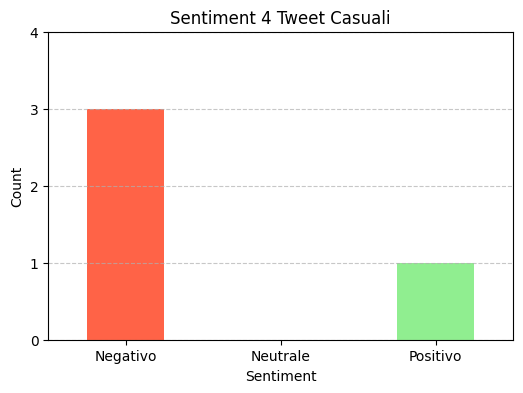

In [ ]:
# Grafico 4 Tweet

results_series = pd.Series(predictions_list)
sentiment_counts = results_series.value_counts()
color_map = {'Negativo': '#FF6347', 'Neutrale': '#B0C4DE', 'Positivo': '#90EE90'}
ordered_counts = sentiment_counts.reindex(['Negativo', 'Neutrale', 'Positivo'], fill_value=0)

plt.figure(figsize=(6, 4))
ordered_counts.plot(kind='bar', color=[color_map.get(label, 'blue') for label in ordered_counts.index])
plt.title('Sentiment 4 Tweet Casuali')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(range(int(ordered_counts.max()) + 2))
plt.show()


=== GRAFICO RIASSUNTIVO SU TUTTO IL TEST SET (1500 TWEET) ===


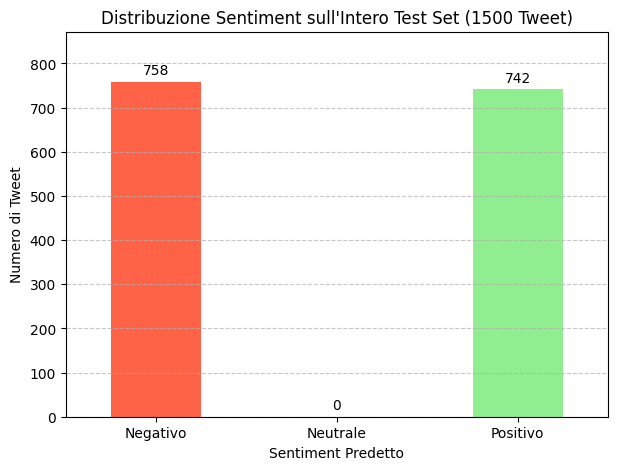

In [ ]:
#Grafico su TUTTO il Test Set

print(f"\n=== GRAFICO RIASSUNTIVO SU TUTTO IL TEST SET ({len(preds)} TWEET) ===")

# --- ECCO LA CORREZIONE ---
# La mappa deve riflettere il NOSTRO modello (0=Neg, 1=Pos)
numeric_label_map = {
    0: "Negativo",
    1: "Positivo"
    # 1 NON è Neutrale
}

# Converti l'array numpy 'preds' in una Serie di pandas
preds_series = pd.Series(preds)
mapped_preds = preds_series.map(numeric_label_map)
sentiment_counts = mapped_preds.value_counts()

# Prepara per il plot
color_map = {'Negativo': '#FF6347', 'Neutrale': '#B0C4DE', 'Positivo': '#90EE90'}
# Assicurati che l'ordine sia corretto per le nostre etichette
ordered_counts = sentiment_counts.reindex(['Negativo', 'Neutrale', 'Positivo'], fill_value=0)

plt.figure(figsize=(7, 5))
bars = ordered_counts.plot(
    kind='bar',
    color=[color_map.get(label, 'blue') for label in ordered_counts.index]
)

plt.title(f'Distribuzione Sentiment sull\'Intero Test Set ({len(preds)} Tweet)')
plt.xlabel('Sentiment Predetto')
plt.ylabel('Numero di Tweet')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.ylim(top=ordered_counts.max() * 1.15)
plt.show()


=== GRAFICI ANDAMENTO VALIDAZIONE ===


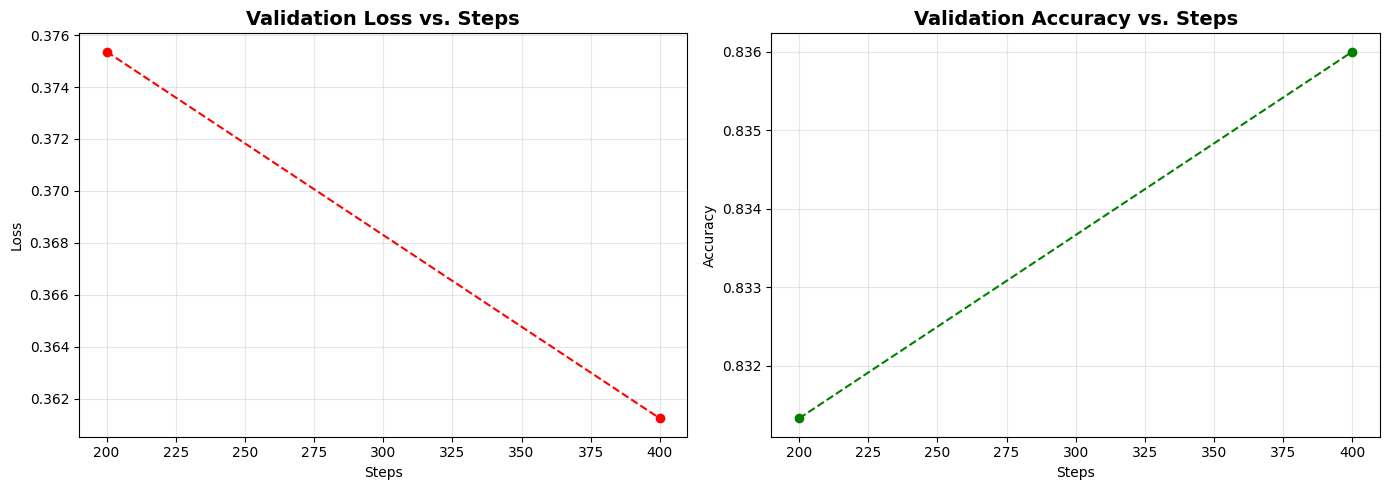

In [ ]:
#Grafici delle Curve di Validazione

print("\n=== GRAFICI ANDAMENTO VALIDAZIONE ===")

#Estrai tutti i log dalla cronologia del trainer
log_history = trainer.state.log_history

#Separa i log di training da quelli di valutazione (eval)
# Cerca solo i dizionari che contengono 'eval_loss'
eval_logs = [log for log in log_history if 'eval_loss' in log]

if not eval_logs:
    print("Nessun log di valutazione trovato.")
    print("Assicurati che 'evaluation_strategy' e 'eval_steps' siano impostati in TrainingArguments.")
else:
    #Estrae i valori per gli assi X e Y
    steps = [log['step'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]
    eval_accuracies = [log['eval_accuracy'] for log in eval_logs]

    #Crea i grafici (due grafici in una sola figura)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Grafico 1: Validation Loss
    ax1.plot(steps, eval_losses, marker='o', linestyle='--', color='red')
    ax1.set_title('Validation Loss vs. Steps', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    # Grafico 2: Validation Accuracy
    ax2.plot(steps, eval_accuracies, marker='o', linestyle='--', color='green')
    ax2.set_title('Validation Accuracy vs. Steps', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()